# Homework Week 04-05
Nicola Zomer <br>
17 November, 2022

## Assignment
1) Generate a random a SxS matrix with C non zero entries and 1-C zeros (C is between zero and one). Set the diagonal to -d. The non-zero elements are drawn  from a given distributions. Calculate the eigenvalues. Repeat different realizations and plot all the eigenvalues in the complex plane [Real part (x-axis) and imaginary part (y-axis)]. Compare this result with the expectations from the circular law. 
   
2) Generate the same as above but for mutualistic structure and find how the maximum real eigenvalues scales with S (use S=20,30,40,..100) and compare your numerical finding with the analytical expectations (we did not explicitly have calculated this in class). 
   
3) Analyse the food web using the metrics we have seen in class. The file represent the weighted adjacency matrix of the food web. For the analysis you can binarize (zero and one) the matrix. You find the file in the google drive.
   
4) (optional) Calculate the same as 1) but with for the cascade model or for the nested mutualistic network. 

In [1]:
import numpy as np
import math as m
import pandas as pd

# dash
from jupyter_dash import JupyterDash
from dash import Dash
## from dash import dcc
## from dash import html
from dash.dependencies import Output, State, Input

# plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

%matplotlib inline

# show static images for github
from IPython.display import Image, display
savegit = True

# Point 1 
## The Circular Law
Consider the Generalized Lotka-Volterra Dynamics, describing the interaction of $S$ species through a network:
$$
    \frac{dN_i}{dt} = a_iN_i(t)- N_i(t)\sum_{j=1}^{S} \alpha_{ij}N_j(t) \quad i=1, ..., S
$$
The Jacobian matrix evaluated at the non-trivial equilibrium point of the system is given by:
$$
    J_{ij}=\frac{\partial \dot{N}_i}{\partial N_j}\Bigr\rvert_{\bar{N}^*} = N_i^*\alpha_{ij}
$$

We consider a stationary point $\bar{N}^*=(1, 1, ...., 1)$, which implies that $J_{ij}=\alpha_{ij}$, and we model $\alpha$ as a random matrix, for example assuming that $\alpha_{ij}$ are drawn from a Gaussian distribution, $\alpha_{ij} \sim \mathcal{N}(0, \sigma^2)$. Assuming interactions are i.i.d. random variables and $\alpha_{ii}=0$ for all $i=1, ..., S$, then all eigenvalues of $\alpha/\sqrt{S\sigma^2}$ are uniformly distributed within the unitary disk in the complex plane. This is called _Circular Law_.

Moreover, if we add the effect of self-interactions and we model it as a constant intra-specied competition, $\alpha_{ii}=-d <0$, then the disk containing all the eigenvalues of $\alpha$ is translated on the real axis, that is:
- the disk center is $(-d, 0)$
- the disk radius is $\sqrt{S\sigma^2}$

Notice that in general $\sigma$ is the standard deviation of the random variable $X$ from which the coefficients $\alpha_{ij}$ take value. 

If we further introduce a constant $C$, called _connectance_, such that with probability $C$ the coefficient of $\alpha_{ij}$ are sampled by the selected distribution and with probability $0$ are set to $0$, than the radius of the disk becomes:
$$
    r= \sqrt{SC\sigma^2}
$$

Pay attention that the Circular Law is verified only if $\alpha$ satisfies 2 conditions:
1. $\mathbb{E}[\alpha_{ij}]=0$, so the interaction matrix has zero mean
2. $\mathbb{E}[\alpha_{ij}, \alpha{ji}]=0$

This conditions depends on the chosen distribution and on how the matrix is built. Notice that they are reached by taking $\mathcal{D} =\mathcal{N}(0, \sigma^2)$ and following the next construction steps. 


## Construction of the Random Matrices
Notation: in this context we call $M_{ij}$ the random matrix, and $\mathcal{D}$ the distribution we have selected (for example $\mathcal{D} =\mathcal{N}(0, \sigma^2)$). 

**Off-diagonal elements** <br>
For each off-diagonal term of the matrix we draw a random value $p$ from a uniform distribution $\mathcal{U}[0, 1]$. If $p\leq C$, we set $M_{ij}$ by sampling it from $\mathcal{D}$, otherwise we impose $M_{ij}=0$

**Diagonal elements** <br>
All diagonal elements, $M_{ii}$, are set to $−d$. 

These matrices, for large S, generate a precise mixture of interaction types, with predator-prey interactions being represented twice as frequently as mutualistic or competitive ones.


In [2]:
# random matrix generation
def randommatrix(size, diag, connectance, D=lambda: np.random.normal(0, 1), mutualistic=False):
    '''
    INPUT:
    - size        -> size of the square matrix (i.e. number of species) 
    - diag        -> value of d (>0)
    - connectance -> value of C (0<C<1)
    - D           -> the selected distribution, by default a gaussian distribution
    - mutualistic -> if True, consider only mutualistic interactions
    
    OUTPUT:
    - M -> the random matrix
    
    '''
    
    assert diag>0, 'diag  must be >0'
    assert 0<connectance<1, 'connectance must be between 0 and 1'
    
    # initialize matrix
    M = np.zeros((size, size))
    
    # 1. off-diagonal elements
    for i in range(size):
        for j in range(i, size):
            p = np.random.uniform()
            
            if p<=connectance:
                if not mutualistic:
                    M[i, j] = D()
                    M[j, i] = D()
                else:
                    M[i, j] = np.abs(D())
                    M[j, i] = np.abs(D())
    
    # 2. diagonal elements
    np.fill_diagonal(M, -diag)

    return M


# circle extremes
def my_circle(center, radius):
    '''
    INPUT:
    - center -> [ , ], center of the disk
    - radius -> float, radius of the disk
    
    OUTPUT: 
    - x0 -> min(x)
    - y0 -> min(y)
    - x1 -> max(x)
    - y1 -> max(y)
    
    '''
    
    x0_ = center[0]-radius
    y0_ = center[1]-radius
    x1_ = center[0]+radius
    y1_ = center[1]+radius

    return x0_, y0_, x1_, y1_


The expected center of the disk is: (-1.00, 0)
The expected radius of the disk is: r = 9.22


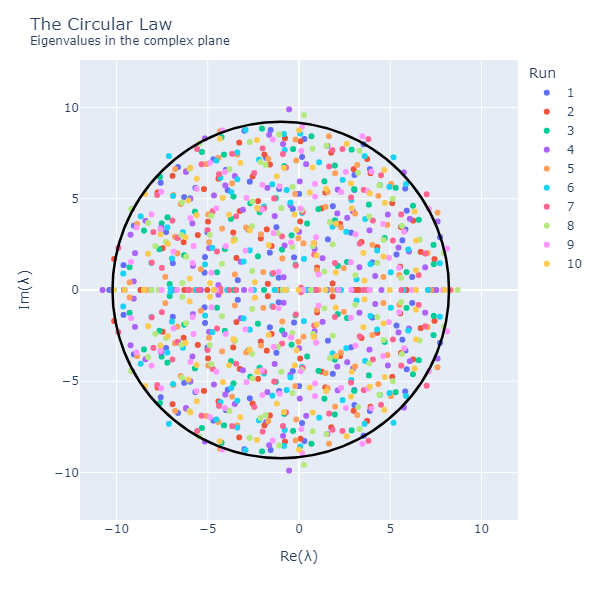

In [3]:
np.random.seed(1245)

# parameters
C = 0.85
d = 1
S = 100
sigma = 1

# center and radius of the circle
center = [-d, 0]
radius = m.sqrt(S*C*sigma**2)

print('The expected center of the disk is: (%.2f, %i)' %(center[0], center[1]))
print('The expected radius of the disk is: r = %.2f' %(radius))


# build N random matrices
N = 10
appended_data = []

for i in range(N):
    df_eig = pd.DataFrame(columns=['re', 'im', 'run'])
    
    M = randommatrix(S, d, C)
    eig_M, _ = np.linalg.eig(M)
    df_eig['re'] = np.real(eig_M)
    df_eig['im'] = np.imag(eig_M)
    df_eig['run'] = [str(i+1)]*len(eig_M)
    
    appended_data.append(df_eig)
    
appended_data = pd.concat(appended_data)

# circle data
x0, y0, x1, y1 = my_circle(center, radius)

# plot the eigenvalues
fig = px.scatter(appended_data, x="re", y="im", color="run")

fig.update_layout(
    title="The Circular Law <br><sup>Eigenvalues in the complex plane</sup>",
    xaxis_title="Re(λ)",
    yaxis_title="Im(λ)",
    legend_title="Run",
    width=600,
    height=600,
)
fig.update_xaxes(range=[-12, 12])
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
    range=[-12, 12]
  )

fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=x0, y0=y0, x1=x1, y1=y1,
    line_color="black",
    line_width = 2.5
)
# fig.add_annotation(
#     x= center[0]+radius,
#     y= center[1],
#     xref="x", yref="y",
#     text="",
#     showarrow=True,
#     axref = "x", ayref='y',
#     ax= center[0],
#     ay= center[1],
#     arrowhead = 3,
#     arrowwidth= 2, 
#     arrowcolor='black')

if savegit: 
    path = "images/hw04_circlaw.png"
    fig.write_image(path)
    display(Image(path))
    
else:
    fig.show()

# Point 2
To  generate the same as above for mutualistic structure simply impose that with probability $C$:
$$
    \{\alpha_{ij}, \alpha{ji}\} = \{|x_1|, |x_2|\}
$$ 
where $x_1$ and $x_2$ are sampled from the distribution $\mathcal{D}$.

## Construction of the Random Matrices in the Mutualistic case
**Off-diagonal elements** <br>
For each pair of off-diagonal terms $\{M{ij}, M{ji}\}$ of the matrix we draw a random value $p$ from a uniform distribution $\mathcal{U}[0, 1]$. If $p\leq C$, we set $M_{ij}$ and $M_{ji}$ by sampling them independently from $|\mathcal{D}|$ (which for example can be the half-normal distribution), otherwise we impose $M_{ij}=M_{ji}=0$

**Diagonal elements** <br>
All diagonal elements, $M_{ii}$, are set to $−d$. 


## Ellipse Law and non-zero mean case
First, notice that in this case the correlation coefficient $\rho$, defined as:
$$
    \rho := \frac{\mathbb{E}[M_{ij}, M_{ji}]-\mathbb{E}^2[M_ij]}{Var(M_{ij})}
$$
is different from zero. This implies a modification of the Circular Law, which is called Elliptical Law. According to this law, the eigenvalues of $M$ are uniformly distributed within an ellipse in the complex plane, whose semi-axes are:
$$
\begin{align}
    a &= \sqrt{SV}(1+\rho) \\
    b &= \sqrt{SV}(1-\rho)
\end{align}
$$
where $V=Var(M_{ij})$. 

Moreover, in this case the interaction matrix has non-zero mean. This leads to an eigenvalue, which in general can be located outside of the ellipse and seen as a sort of outlier, such that:
$$
    Re(\lambda) = -d+(S-1)\mathbb{E}[M_ij]
$$ 
Not only this, but also the center of the ellipse is moved in $(-d-\mathbb{E}[M_{ij}], 0)$.



In [4]:
# rho numerical estimate
def correlation_numerical(M):
    '''
    INPUT: matrix M
    OUTPUT: expected correlation rho between Mij and Mji
    
    '''
    
    E_aij = M.mean()
    E_aij_aji = np.mean((M*M.T)[np.triu_indices(M.shape[0])])
    Var_aij = M.var()
    
    return (E_aij_aji - E_aij**2)/Var_aij


# outlier numerical estimate
def outlier_numerical(M, species):
    '''
    INPUT:
    - species  -> float, number of species
    - M        -> interaction matrix M
    
    OUTPUT: Re(lambda)
    
    '''
    
    return -d+(species-1)*M.mean()


# ellipse extremes
def my_ellipse(center, species, variance, rho):
    '''
    INPUT:
    - center   -> [ , ], center of the ellipse
    - species  -> float, number of species
    - variance -> variance of the interaction matrix
    - rho      -> correlation coefficient
    
    OUTPUT: 
    - x0 -> min(x)
    - y0 -> min(y)
    - x1 -> max(x)
    - y1 -> max(y)
    
    '''
        
    radius = np.sqrt(species*variance)
    a = radius*(1+rho)
    b = radius*(1-rho)
    
    x0_ = center[0]-a
    y0_ = center[1]-b
    x1_ = center[0]+a
    y1_ = center[1]+b

    return x0_, y0_, x1_, y1_

## Numerical approach
Here all results are achived numerically, not taking into account the distribution used. At each iteration
- $\mathbb{E}[M_{ij}]$
- $\mathbb{E}[M_{ij}, M_{ji}]$
- $Var(M_{ij})$

are estimated numerically from the costructed matrix. Their final estimated value is obtained by averaging over the iterations. 

In [5]:
np.random.seed(1245)

# build N random matrices, with mutualistic structure
N = 10
appended_data   = []
rho_values      = []
mean_values     = []
variance_values = []
outlier_values  = []

for i in range(N):
    df_eig = pd.DataFrame(columns=['re', 'im', 'run'])
    
    M = randommatrix(S, d, C, mutualistic=True)
    eig_M, _ = np.linalg.eig(M)
    df_eig['re'] = np.real(eig_M)
    df_eig['im'] = np.imag(eig_M)
    df_eig['run'] = [str(i+1)]*len(eig_M)
    
    appended_data.append(df_eig)
    rho_values.append(correlation_numerical(M))
    variance_values.append(np.var(M))
    mean_values.append(np.mean(M))
    outlier_values.append(outlier_numerical(M, S))
    
appended_data = pd.concat(appended_data)
rho = np.mean(rho_values)
variance_M = np.mean(variance_values)
expected_M = np.mean(mean_values)

out_lambda = np.mean(outlier_values)

# ellipse data
center = [-d-expected_M, 0]
print('The expected center of the ellipse is: (%.2f, %i)' %(center[0], center[1]))

x0, y0, x1, y1 = my_ellipse(center, S, variance_M, rho)

# estimate outlier
print('Outlier eigenvalue: %.2f' %out_lambda)


The expected center of the ellipse is: (-1.66, 0)
Outlier eigenvalue: 64.22


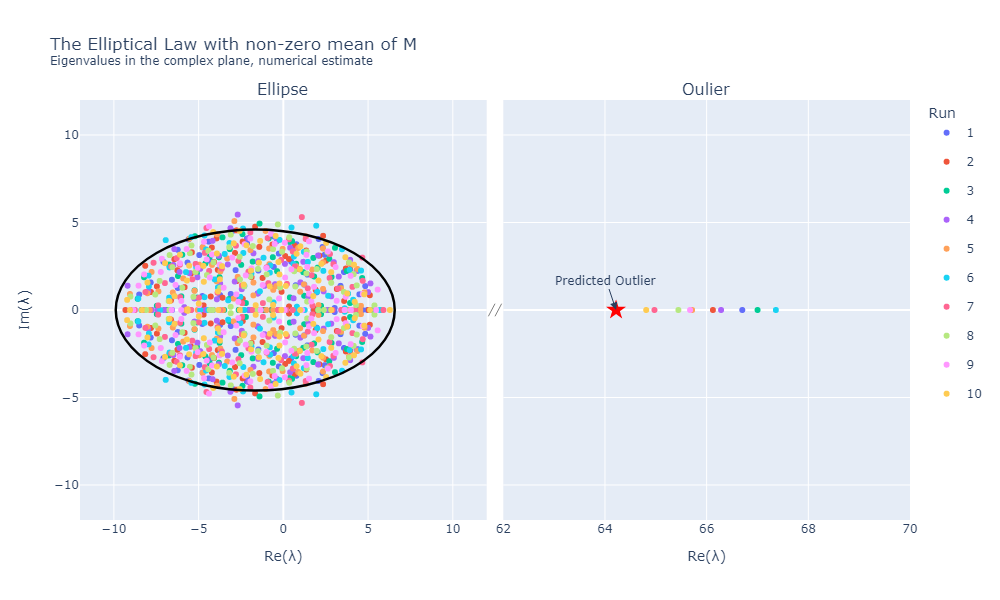

In [6]:
# plot data
df1 = appended_data[appended_data['re']<20]
df2 = appended_data[appended_data['re']>20]

# organize datafames with different x-axes in a dict
dfs = {'df1': df1,
       'df2': df2
}

# subplot setup
colors = px.colors.qualitative.Plotly
fig = make_subplots(rows=1, cols=len(dfs.keys()), horizontal_spacing = 0.02, subplot_titles=("Ellipse", "Oulier"))

# Assign columns from dataframes in dict to the correct subplot
for i, dfd in enumerate(dfs, start =1):
    for j, run in enumerate(dfs[dfd]['run'].unique()):
        df_ = dfs[dfd]
        df_ = df_[df_['run']==run]
        fig.add_trace(go.Scatter(x=df_['re'],
                        y=df_['im'],
                        mode = 'markers',
                        name=run,
                        marker_color=colors[j],
                        legendgroup = run,
                        showlegend = True if i == 1 else False,
                        ), row=1, col=i)

# ellipse
fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=x0, y0=y0, x1=x1, y1=y1,
    line_color="black",
    line_width = 2.5
)

# predicted outlier 
fig.add_trace(go.Scatter(x=[out_lambda], y=[0], 
                        mode = 'markers',
                        marker_color = 'red',
                        marker_symbol = 'star',
                        showlegend=False,
                        marker_size = 15), row=1, col=2)

fig.add_annotation(x=out_lambda, y=0,
            text="Predicted Outlier",
            showarrow=True,
            arrowhead=2,
            arrowsize=1.5,
            arrowwidth=1,
            row=1, col=2)

# make the plot nice
fig.update_yaxes(range=[-12, 12], )
fig.update_yaxes(showticklabels=False, row=1, col=2)

fig.update_xaxes(range=[-12, 12], title_text='Re(λ)', row=1, col=1)
fig.update_xaxes(range=[62, 70], title_text='Re(λ)', row=1, col=2)

# a little aesthetic adjustment
fig.add_shape(type="line",
    x0=0.50, y0=0.5-0.015, x1=0.508, y1=0.5+0.015,
    line=dict(color="grey",width=1),
    xref = 'paper',
    yref = 'paper'
)

fig.add_shape(type="line",
    x0=0.492, y0=0.5-0.015, x1=0.5, y1=0.5+0.015,
    line=dict(color="grey",width=1),
    xref = 'paper',
    yref = 'paper'
)

# layout
fig.update_layout(
    height=600, width=1000, 
    title_text="The Elliptical Law with non-zero mean of M <br><sup>Eigenvalues in the complex plane, numerical estimate</sup>", 
    yaxis_title="Im(λ)",
    legend_title="Run")

if savegit: 
    path = "images/hw04_ellipticallaw_numerical.png"
    fig.write_image(path)
    display(Image(path))
    
else:
    fig.show()
    

## Analytical expectations
The above quantities can be computed analytically, in particular considering the case $\mathcal{D}=\mathcal{N}(0, \sigma^2)$. In this case the values of $M_{ij}$ and $M_{ji}$ are drawn independently from a half-normal distribution. 

The expected value of $M_{ij}$ can be easily obtained from the expected value of the half-normal distribution, indeed:
$$
    \mathbb{E}[M_{ij}] = C \cdot\mathbb{E}[X]\bigr|_{X\sim |\mathcal{N}(0, \sigma^2)|} = C \cdot \frac{2\sigma}{\sqrt{2\pi}}
$$

Similarly, it is possible to compute $\mathbb{E}[M_{ij}, M_{ji}]$:
$$
    \mathbb{E}[M_{ij}, M_{ji}] = C \cdot\mathbb{E}^2[X]\bigr|_{X\sim |\mathcal{N}(0, \sigma^2)|} = C \cdot \frac{2\sigma^2}{\pi}
$$

Finally, we can get also the variance of $M_{ij}$:
$$
    Var(M_{ij}) = \mathbb{E}[M^2_{ij}] - \mathbb{E}^2[M_{ij}] = C\left[\sigma^2-C\cdot\frac{2\sigma^2}{\pi}\right] = C\sigma^2\left(1-\frac{2C}{\pi}\right)
$$

Having all these quantities, we can derive the correlation $\rho$ and the semi-axes of the ellipse:
$$
\begin{align}
    &\rho = \frac{\mathbb{E}[M_{ij}, M_{ji}] - \mathbb{E}^2[M_{ij}]}{Var(M_{ij})} = \frac{C \cdot\frac{2\sigma^2}{\pi} - C^2 \cdot\frac{2\sigma^2}{\pi}}{C\cdot\sigma^2 \left(1-\frac{2C}{\pi} \right)} = \frac{1 - C}{\frac{\pi}{2}-C}\\
    &a = \sqrt{SV}(1 +\rho) = \sqrt{SC\sigma^2 \left( 1 - \frac{2C}{\pi} \right)} \cdot\left(1 + \frac{1-C}{\frac{\pi}{2}-C}\right) \\
    &b = \sqrt{SV}(1 -\rho) = \sqrt{SC\sigma^2 \left( 1 - \frac{2C}{\pi} \right)} \cdot\left(1 - \frac{1-C}{\frac{\pi}{2}-C}\right) 
\end{align}
$$

Finally, the eigenvalue that comes from the fact that the interaction matrix has non-zero mean can be computed as:
$$
    Re(\lambda) = -d+(S-1)\mathbb{E}[M_ij] = -d+C(S-1)\frac{2\sigma}{\sqrt{2\pi}}
$$  




   

In [7]:
np.random.seed(1245) # same as above

# build N random matrices, with mutualistic structure
N = 10
appended_data   = []

for i in range(N):
    df_eig = pd.DataFrame(columns=['re', 'im', 'run'])
    
    M = randommatrix(S, d, C, mutualistic=True)
    eig_M, _ = np.linalg.eig(M)
    df_eig['re'] = np.real(eig_M)
    df_eig['im'] = np.imag(eig_M)
    df_eig['run'] = [str(i+1)]*len(eig_M)
    
    appended_data.append(df_eig)
    
appended_data = pd.concat(appended_data)

# variance and rho
V = C*sigma**2*(1-(2*C)/np.pi)
rho =(1-C)/((np.pi/2)-C)

# ellipse data
center = [-d-C*(2*sigma)/np.sqrt(2*np.pi), 0]
print('The expected center of the ellipse is: (%.2f, %i)' %(center[0], center[1]))

x0, y0, x1, y1 = my_ellipse(center, S, V, rho)

# estimate outlier
out_lambda =  -d + (S-1)*C*(2*sigma)/(np.sqrt(2*np.pi))
print('Outlier eigenvalue: %.2f' %out_lambda)


The expected center of the ellipse is: (-1.68, 0)
Outlier eigenvalue: 66.14


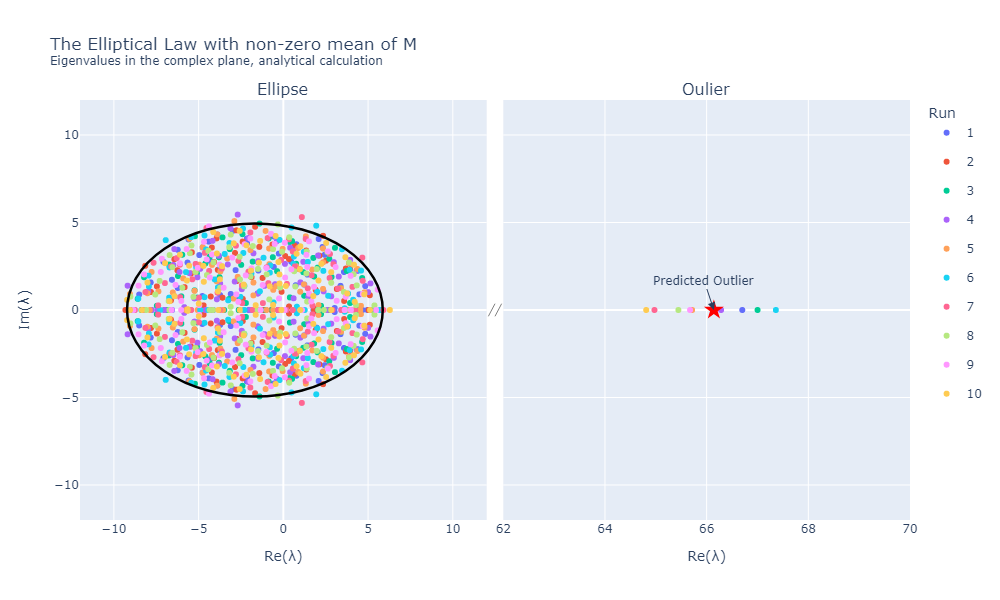

In [8]:
# plot data
df1 = appended_data[appended_data['re']<20]
df2 = appended_data[appended_data['re']>20]

# organize datafames with different x-axes in a dict
dfs = {'df1': df1,
       'df2': df2
}

# subplot setup
colors = px.colors.qualitative.Plotly
fig = make_subplots(rows=1, cols=len(dfs.keys()), horizontal_spacing = 0.02, subplot_titles=("Ellipse", "Oulier"))

# Assign columns from dataframes in dict to the correct subplot
for i, dfd in enumerate(dfs, start =1):
    for j, run in enumerate(dfs[dfd]['run'].unique()):
        df_ = dfs[dfd]
        df_ = df_[df_['run']==run]
        fig.add_trace(go.Scatter(x=df_['re'],
                        y=df_['im'],
                        mode = 'markers',
                        name=run,
                        marker_color=colors[j],
                        legendgroup = run,
                        showlegend = True if i == 1 else False,
                        ), row=1, col=i)

# ellipse
fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=x0, y0=y0, x1=x1, y1=y1,
    line_color="black",
    line_width = 2.5
)

# predicted outlier 
fig.add_trace(go.Scatter(x=[out_lambda], y=[0], 
                        mode = 'markers',
                        marker_color = 'red',
                        marker_symbol = 'star',
                        showlegend=False,
                        marker_size = 15), row=1, col=2)

fig.add_annotation(x=out_lambda, y=0,
            text="Predicted Outlier",
            showarrow=True,
            arrowhead=2,
            arrowsize=1.5,
            arrowwidth=1,
            row=1, col=2)

# make the plot nice
fig.update_yaxes(range=[-12, 12], )
fig.update_yaxes(showticklabels=False, row=1, col=2)

fig.update_xaxes(range=[-12, 12], title_text='Re(λ)', row=1, col=1)
fig.update_xaxes(range=[62, 70], title_text='Re(λ)', row=1, col=2)

# a little aesthetic adjustment
fig.add_shape(type="line",
    x0=0.50, y0=0.5-0.015, x1=0.508, y1=0.5+0.015,
    line=dict(color="grey",width=1),
    xref = 'paper',
    yref = 'paper'
)

fig.add_shape(type="line",
    x0=0.492, y0=0.5-0.015, x1=0.5, y1=0.5+0.015,
    line=dict(color="grey",width=1),
    xref = 'paper',
    yref = 'paper'
)

# layout
fig.update_layout(
    height=600, width=1000, 
    title_text="The Elliptical Law with non-zero mean of M <br><sup>Eigenvalues in the complex plane, analytical calculation</sup>", 
    yaxis_title="Im(λ)",
    legend_title="Run")

if savegit: 
    path = "images/hw04_ellipticallaw_analytical.png"
    fig.write_image(path)
    display(Image(path))
    
else:
    fig.show()
    

## Scaling of the Maximum Eighenvalue
In the general setting where $V=Var(M_{ij})$ and $C\mu=\mathbb{E}[M_{ij}]$, the maximum eigenvalue $\lambda_{max}$ is given by:
$$
    \lambda_{max} = max\left\{\sqrt{SV}(1\pm\rho)-C\mu-d \quad , \quad (S-1)C\mu-d \right\}
$$

In the mutualistic case, using the quantities derived above and the fact that $\rho>0$, this expression becomes:
$$
    \lambda_{max} = max\left\{\sqrt{SC\sigma^2\left(1-\frac{2C}{\pi}\right)}\left(1+\frac{1 - C}{\frac{\pi}{2}-C}\right)-C \frac{2\sigma}{\sqrt{2\pi}}-d \quad , \quad (S-1)C \frac{2\sigma}{\sqrt{2\pi}}-d \right\}
$$

As can be seen from the plots above, the second term should prevail over the first, leading to a linear scale of $\lambda_{max}$ with the number of species $S$.

In [9]:
def predict_lambda_max(species):
    ellipse_ = np.sqrt(species*C*sigma**2*(1-2*C/np.pi))*(1+(1-C)/(np.pi/2-C))-C*2*sigma/np.sqrt(2*np.pi)-d
    outlier_ = (species-1)*C*2*sigma/np.sqrt(2*np.pi)-d
    
    return np.max([ellipse_, outlier_])

,Maxeig,Predicted,S
0,12.30,11.89,20
1,18.73,18.67,30
2,25.60,25.45,40
3,32.31,32.23,50
4,38.84,39.01,60
5,45.94,45.80,70
6,52.71,52.58,80
7,59.38,59.36,90
8,66.43,66.14,100


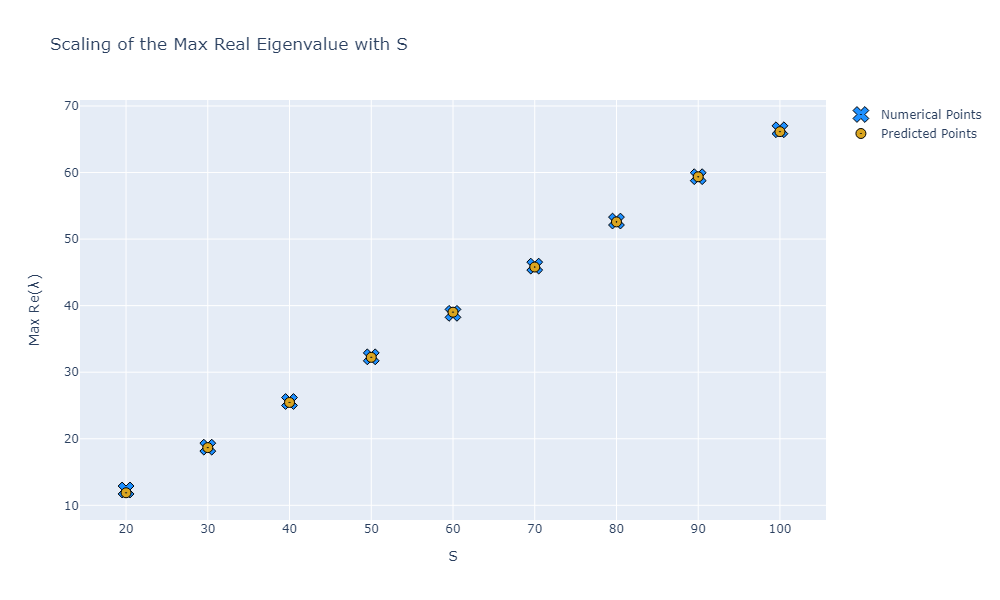

In [10]:
np.random.seed(1245)

# setting
S_vec = np.arange(20, 110, 10).astype(int)  # number of species
N = 10                                      # number of iterations for each # species (take the average value)

df_max_re = pd.DataFrame(columns=['Maxeig', 'Predicted', 'S'])

# build the random matrices and find the max real eigenvalue
for s in S_vec:
    max_eig = []
    for i in range(N):
        M = randommatrix(s, d, C, mutualistic=True)
        eig_M, _ = np.linalg.eig(M)
        
        max_eig.append(np.max(np.real(eig_M)))
        
    lambda_pred = predict_lambda_max(s)
    
    df_max_re = df_max_re.append({'Maxeig': np.average(max_eig), 'Predicted': lambda_pred, 'S':str(s)}, ignore_index=True)
    
        
display(df_max_re.round(2))

# plot
fig = go.Figure(data=go.Scatter(x=df_max_re['S'], y=df_max_re['Maxeig'], 
                                mode = 'markers',
                                marker_color = 'dodgerblue',
                                marker_symbol = 'x-dot',
                                marker_size = 14,
                                showlegend=True,
                                name='Numerical Points')
)

fig.add_trace(go.Scatter(x=df_max_re['S'], y=df_max_re['Predicted'], 
                        mode = 'markers',
                        marker_color = 'goldenrod',
                        marker_symbol = 'circle-dot',
                        marker_size = 10,
                        showlegend=True,
                        name='Predicted Points')
)

fig.update_layout(
    title="Scaling of the Max Real Eigenvalue with S",
    xaxis_title="S",
    yaxis_title="Max Re(λ)",
    width=1000,
    height=600
)
fig.update_traces(
    marker = dict(line=dict(width=1, color='Black')
    )
)

if savegit: 
    path = "images/hw04_scaling_maxeig.png"
    fig.write_image(path)
    display(Image(path))
    
else:
    fig.show()

# Additional 1: other structures
- Predator - Prey Structure
- Competitive + Mutualistic Structure

## Construction of the Random Matrices in the Predator-Prey case
**Off-diagonal elements** <br>
For each pair of off-diagonal terms $\{M{ij}, M{ji}\}$ of the matrix we draw a random value $p$ from a uniform distribution $\mathcal{U}[0, 1]$. 
- If $p\leq C/2$, we set $M_{ij}$ and $M_{ji}$ by sampling them independently from, respectively, $|\mathcal{D}|$ and $-|\mathcal{D}|$.
- If $C/2<p\leq C$, we do the opposite.
- If $p>C$ we impose $M_{ij}=M_{ji}=0$.

**Diagonal elements** <br>
All diagonal elements, $M_{ii}$, are set to $−d$. 


## Construction of the Random Matrices in the Competitive-Mutualistic case
**Off-diagonal elements** <br>
For each pair of off-diagonal terms $\{M{ij}, M{ji}\}$ of the matrix we draw a random value $p$ from a uniform distribution $\mathcal{U}[0, 1]$. 
- If $p\leq C/2$, we set $M_{ij}$ and $M_{ji}$ by sampling them independently from $|\mathcal{D}|$ (so here the half-normal distribution).
- If $C/2<p\leq C$, we draw them from $-|\mathcal{D}|$ (so here the negative half-normal distribution).
- If $p>C$ we impose $M_{ij}=M_{ji}=0$.

**Diagonal elements** <br>
All diagonal elements, $M_{ii}$, are set to $−d$. 

In [11]:
# random matrix generation, competitive + mutualistic or predator-prey
def randommatrix_cm_pp(size, diag, connectance, D=lambda: np.random.normal(0, 1), competitivemutualistic=True):
    '''
    INPUT:
    - size                   -> size of the square matrix (i.e. number of species) 
    - diag                   -> value of d (>0)
    - connectance            -> value of C (0<C<1)
    - D                      -> the selected distribution, by default a gaussian distribution
    - competitivemutualistic -> if true, competitive + mutualistic, else predator-prey interaction
    
    OUTPUT:
    - M -> the random matrix
    
    '''
    
    assert diag>0, 'diag  must be >0'
    assert 0<connectance<1, 'connectance must be between 0 and 1'
    
    # initialize matrix
    M = np.zeros((size, size))
    
    # 1. off-diagonal elements
    for i in range(size):
        for j in range(i+1, size):
            p = np.random.uniform()
                
            if p<=connectance/2:
                if competitivemutualistic: 
                    # mutualistic pair of species
                    M[i, j] = np.abs(D())
                    M[j, i] = np.abs(D())
                else:
                    # predator-prey interaction (ij>0, ji<0)
                    M[i, j] = np.abs(D())
                    M[j, i] = -np.abs(D())
                
            elif connectance/2<p<=connectance:
                if competitivemutualistic:
                    # competitive pair of species
                    M[i, j] = -np.abs(D())
                    M[j, i] = -np.abs(D())
                else:
                    # predator-prey interaction (ij<0, ji>0)
                    M[i, j] = -np.abs(D())
                    M[j, i] = np.abs(D())
    
    # 2. diagonal elements
    np.fill_diagonal(M, -diag)

    return M


# rho knowing the distribution
def correlation_zeromean(M, connectance, sigma):
    '''
    INPUT: matrix M, connectance, standard deviation sigma (mean is taken as zero)
    OUTPUT: expected correlation rho between Mij and Mji
    
    '''
    E_aij_aji = np.mean((M*M.T)[np.triu_indices(M.shape[0])])
    
    return (E_aij_aji)/(connectance*sigma**2)

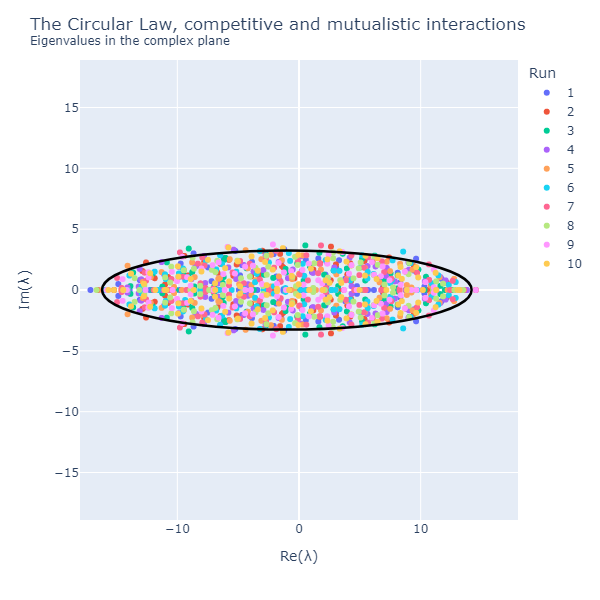

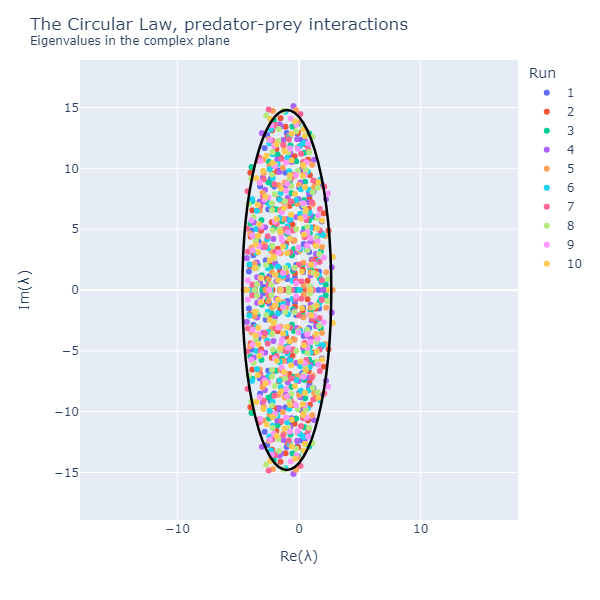

In [12]:
np.random.seed(1245)

# parameters
C = 0.85
d = 1
S = 100
sigma = 1

# center and radius of the circle
center = [-d, 0]
radius = m.sqrt(S*C*sigma**2)

# initialize lists
N = 10
appended_data_cm = []
appended_data_pp = []

# build N random matrices with competitive + mutualistic structure
rho_values = []

for i in range(N):
    df_eig = pd.DataFrame(columns=['re', 'im', 'run'])
    
    M = randommatrix_cm_pp(S, d, C, competitivemutualistic=True)
    eig_M, _ = np.linalg.eig(M)
    df_eig['re'] = np.real(eig_M)
    df_eig['im'] = np.imag(eig_M)
    df_eig['run'] = [str(i+1)]*len(eig_M)
    
    appended_data_cm.append(df_eig)
    rho_values.append(correlation_zeromean(M, C, sigma))
    
appended_data_cm = pd.concat(appended_data_cm)
rho_cm = np.mean(rho_values)

# build N random matrices with predator-prey structure
rho_values = []

for i in range(N):
    df_eig = pd.DataFrame(columns=['re', 'im', 'run'])
    
    M = randommatrix_cm_pp(S, d, C, competitivemutualistic=False)
    eig_M, _ = np.linalg.eig(M)
    df_eig['re'] = np.real(eig_M)
    df_eig['im'] = np.imag(eig_M)
    df_eig['run'] = [str(i+1)]*len(eig_M)
    
    appended_data_pp.append(df_eig)
    rho_values.append(correlation_zeromean(M, C, sigma))
    
appended_data_pp = pd.concat(appended_data_pp)
rho_pp = np.mean(rho_values)

# ellipses data
x0_cm, y0_cm, x1_cm, y1_cm = my_ellipse(center, S, C*sigma**2, rho_cm)
x0_pp, y0_pp, x1_pp, y1_pp = my_ellipse(center, S, C*sigma**2, rho_pp)

# plot cm eigenvalues
fig = px.scatter(appended_data_cm, x="re", y="im", color="run")

fig.update_layout(
    title="The Circular Law, competitive and mutualistic interactions<br><sup>Eigenvalues in the complex plane</sup>",
    xaxis_title="Re(λ)",
    yaxis_title="Im(λ)",
    legend_title="Run",
    width=600,
    height=600,
)
fig.update_xaxes(range=[-18, 18])
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
    range=[-18, 18]
  )

fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=x0_cm, y0=y0_cm, x1=x1_cm, y1=y1_cm,
    line_color="black",
    line_width = 2.5
)

if savegit: 
    path = "images/hw04_compmutual.png"
    fig.write_image(path)
    display(Image(path))
    
else:
    fig.show()

# plot pp eigenvalues
fig = px.scatter(appended_data_pp, x="re", y="im", color="run")

fig.update_layout(
    title="The Circular Law, predator-prey interactions<br><sup>Eigenvalues in the complex plane</sup>",
    xaxis_title="Re(λ)",
    yaxis_title="Im(λ)",
    legend_title="Run",
    width=600,
    height=600,
)
fig.update_xaxes(range=[-18, 18])
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
    range=[-18, 18]
  )

fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=x0_pp, y0=y0_pp, x1=x1_pp, y1=y1_pp,
    line_color="black",
    line_width = 2.5
)

if savegit: 
    path = "images/hw04_predatorprey.png"
    fig.write_image(path)
    display(Image(path))
    
else:
    fig.show()
    

# Point 3
Real structures, as the food web, present a hierarchical structure of predation, where:
- **T** are the top predators
- **I** are the intermediate predators
- **B** are the basal species, so species that do not predate and represent the ground zero of resources of the ecosystem.

The food web can be organized in a food chain: a complex directed graph $G(\mathcal{V}, \mathcal{E})$ characterized by paths connecting species of different trophic levels. Each note $v\in\mathcal{V}$ in the graph represents a different species, while each edge $l\in\mathcal{E}$ describes the relationship between the nodes. In our convention, a directed link from node $i$ to node $j$ indicates that species $i$ is predated by $j$. As for any network, we can associate an adjacency matrix $A$ to the food chain, denoting with $a_{ij}$ a connection from $i$ to $j$. 

Moreover, we call:
- $S$ the number of species
- $L$ the number of links

For the following analysis the adjacency matrix is binarized, meaning that all entries different from $0$ are set equal to $1$. In this setting we are not taking into account the strength of the interactions and:
$$
\begin{cases}
    a_{ij} = 1 \quad \text{if $i$ and $j$ have a prey-predator relationship} \\
    a_{ij} = 0 \quad \text{if $i$ and $j$ do not interact} 
\end{cases}
$$



In [13]:
data = pd.read_excel('data/Food-web-Dataset-PNAS-05.xls')
display(data.head())

adj_matrix = np.array(data.drop(columns=['prey\predator']))

# binarize the matrix
mask = adj_matrix > 0 
adj_matrix[mask] = 1
adj_matrix[~mask] = 0 

# convert to pandas and save the data
data_binarized = pd.DataFrame(adj_matrix, columns=data.columns[1:], index=data.columns[1:])
# display(data_binarized.head())

data_binarized.to_excel('data/Food-web-Dataset-PNAS-05-BINARIZED.xlsx')

# compute S, L
S = adj_matrix.shape[0]     # number of species
L = np.sum(adj_matrix)      # number of connections

print('Number of species: %i' %S)
print('Number of links: %i' %L)

,prey\predator,D1,A1,A2,A3,I1,I2,I3,I4,I5,...,F199,F200,F201,F202,F203,F204,F205,F206,F207,F208
0,D1,0,0,0,0,0.000000,0.000226,0.000006,0.000001,0.000001,...,0.0,0.0,0.0,0.0,0.0,0.0,0,2.266301e-07,3.244932e-07,0.0
1,A1,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0,4.724895e-06,1.682557e-06,0.0
2,A2,0,0,0,0,0.000000,0.000000,0.000000,0.000022,0.000022,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1.016026e-06,0.000000e+00,0.0
3,A3,0,0,0,0,0.026745,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000e+00,0.000000e+00,0.0
4,I1,0,0,0,0,0.000000,0.000000,0.000000,0.000685,0.000685,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000e+00,0.000000e+00,0.0


Number of species: 249
Number of links: 3313


### Generality of species $i$
How many different prey the predator predates:
$$
    G_i = \frac{1}{LS}\sum_{j=1}^S a_{ji}
$$

In [14]:
gen = np.sum(adj_matrix, axis=0)/(L*S)

df_ = pd.DataFrame(gen, index=data.columns[1:], columns=['Generality'])
display(df_)

,Generality
D1,0.000000
A1,0.000000
A2,0.000000
A3,0.000000
I1,0.000002
...,...
F204,0.000032
F205,0.000000
F206,0.000021
F207,0.000019


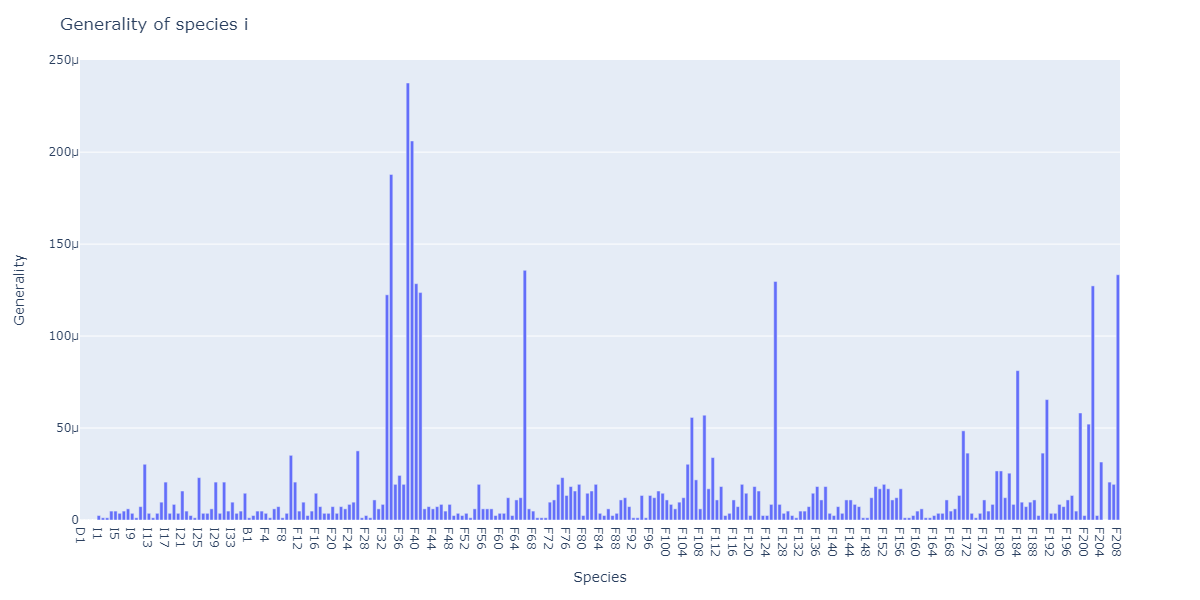

In [15]:
fig = px.bar(df_.reset_index(), x='index', y='Generality')

fig.update_layout(
    title="Generality of species i",
    xaxis_title="Species",
    yaxis_title="Generality",
    width=1200,
    height=600
)

if savegit: 
    path = "images/hw04_generality.png"
    fig.write_image(path)
    display(Image(path))
    
else:
    fig.show()


### Vulnerability of species $i$
How many predators predate the species $i$:
$$
    V_i = \frac{1}{LS}\sum_{j=1}^S a_{ij}
$$

In [16]:
vuln= np.sum(adj_matrix, axis=1)/(L*S)

df_ = pd.DataFrame(vuln, index=data.columns[1:], columns=['Vulnerability'])
display(df_)

,Vulnerability
D1,0.000059
A1,0.000085
A2,0.000036
A3,0.000015
I1,0.000028
...,...
F204,0.000008
F205,0.000016
F206,0.000005
F207,0.000013


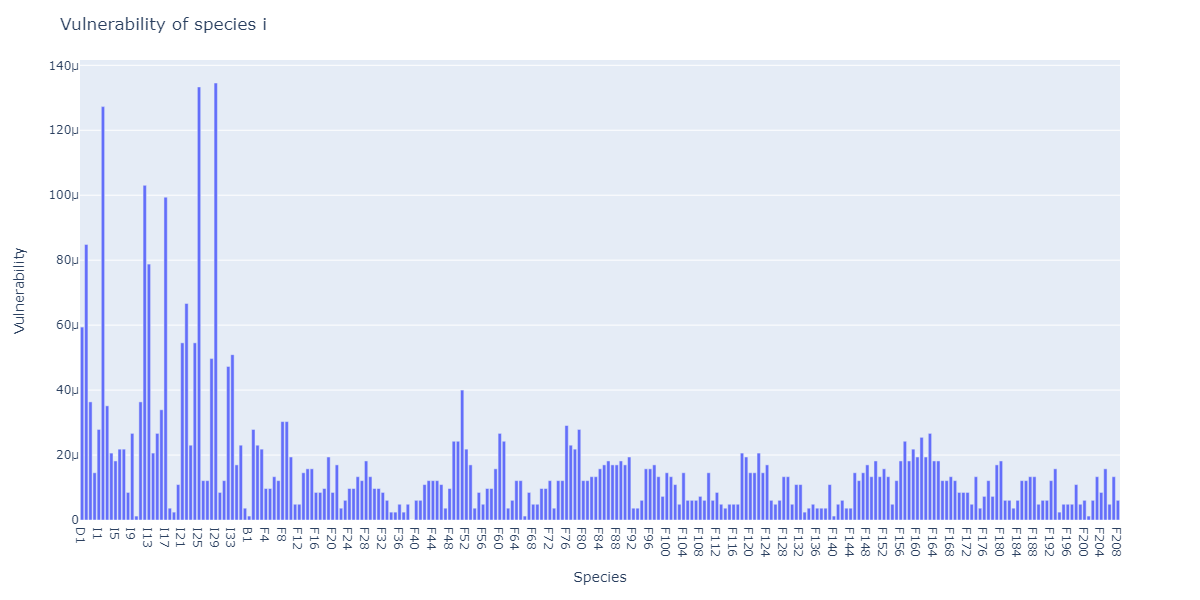

In [17]:
fig = px.bar(df_.reset_index(), x='index', y='Vulnerability')

fig.update_layout(
    title="Vulnerability of species i",
    xaxis_title="Species",
    yaxis_title="Vulnerability",
    width=1200,
    height=600
)

if savegit: 
    path = "images/hw04_vulnerability.png"
    fig.write_image(path)
    display(Image(path))
    
else:
    fig.show()

### Trophic Similarity
The trophic similatity $S_{ij}$ between species $i$ and $j$ takes into account the fact that 2 species can share:
- the same prey $\Rightarrow a_{ki}=a_{kj}=1$
- the same predator $\Rightarrow a_{ik}=a_{jk}=1$

$$
    S_{ij} = \frac{1}{S}\sum_{k=1}^S (a_{ki}a_{kj} + a_{ik}a_{jk})
$$

In [18]:
trop_sim = 1/S*(adj_matrix.T.dot(adj_matrix)+adj_matrix.dot(adj_matrix.T))

df_ = pd.DataFrame(trop_sim, index=data.columns[1:], columns=data.columns[1:])
print('Trophic Similarity:')
display(df_)

Trophic Similarity:


,D1,A1,A2,A3,I1,I2,I3,I4,I5,I6,...,F199,F200,F201,F202,F203,F204,F205,F206,F207,F208
D1,0.196787,0.116466,0.052209,0.040161,0.052209,0.132530,0.032129,0.036145,0.016064,0.024096,...,0.004016,0.004016,0.004016,0.008032,0.008032,0.004016,0.008032,0.000000,0.004016,0.008032
A1,0.116466,0.281124,0.096386,0.008032,0.032129,0.136546,0.108434,0.064257,0.052209,0.060241,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004016,0.000000
A2,0.052209,0.096386,0.120482,0.000000,0.024096,0.068273,0.060241,0.052209,0.044177,0.040161,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A3,0.040161,0.008032,0.000000,0.048193,0.028112,0.048193,0.008032,0.004016,0.004016,0.004016,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
I1,0.052209,0.032129,0.024096,0.028112,0.100402,0.068273,0.016064,0.016064,0.012048,0.012048,...,0.004016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004016,0.004016,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F204,0.004016,0.000000,0.000000,0.000000,0.000000,0.004016,0.000000,0.000000,0.000000,0.000000,...,0.096386,0.024096,0.064257,0.060241,0.024096,0.132530,0.024096,0.012048,0.008032,0.060241
F205,0.008032,0.000000,0.000000,0.000000,0.000000,0.004016,0.000000,0.000000,0.000000,0.000000,...,0.012048,0.016064,0.004016,0.012048,0.044177,0.024096,0.052209,0.016064,0.032129,0.012048
F206,0.000000,0.000000,0.000000,0.000000,0.004016,0.008032,0.004016,0.012048,0.012048,0.008032,...,0.008032,0.008032,0.004016,0.016064,0.008032,0.012048,0.016064,0.084337,0.060241,0.016064
F207,0.004016,0.004016,0.000000,0.000000,0.004016,0.004016,0.004016,0.008032,0.008032,0.008032,...,0.008032,0.004016,0.004016,0.016064,0.024096,0.008032,0.032129,0.060241,0.108434,0.020080


### Trophic level of species $i$
It is defined as the level of species $i$ in the food chain and can be computed as:
$$
    S_i = 
    \begin{cases}
        1+\frac{1}{k_i^{in}}\sum_{j<i} a_{ji}S_j \quad \text{if} \quad i\neq B\\
        1  \quad \text{if} \quad i=B
    \end{cases}
$$
where $k_i^{in}$ is the _in-degree_, so the number of entering links to node $i$, which in this case corresponds to the number of species that $i$ predates. Notice that it is a recursive relationship.

With our convention, $k_i^{in}$ can be obtained as:
$$
    k^{in} = A^T \cdot \mathbf{1} \quad , \quad \mathbf{1} = (\underbrace{1, ..., 1}_{\text{S times}})
$$

Recall that a basal species $B$ does not predate, so it is characterized by $k_B^{in}=0$.

In [19]:
k_in = adj_matrix.T.dot(np.ones(adj_matrix.shape[0]))
tl_vec = np.zeros(S)

def trophic_level(node):  
    
    if k_in[node] == 0:
        tl_vec[node] = 1
        return 
    
    tl_vec[node] = 1
    uni = np.where(adj_matrix[:, node]==1)[0]
    
    for x in uni:
        if tl_vec[x] == 0:
            trophic_level(x)
            
        tl_vec[node] += tl_vec[x]/k_in[node]
        
    return 
             

for i in range(S):
    if tl_vec[i]==0:
        trophic_level(i)
    

In [20]:
df_tl = pd.DataFrame(index=data.columns[1:], columns=['in-degree', 'trophic-level'])
df_tl['in-degree'] = k_in
df_tl['trophic-level'] = tl_vec

display(df_tl)

,in-degree,trophic-level
D1,0.0,1.000000
A1,0.0,1.000000
A2,0.0,1.000000
A3,0.0,1.000000
I1,2.0,2.500000
...,...,...
F204,26.0,4.743971
F205,0.0,1.000000
F206,17.0,3.557709
F207,16.0,3.579289


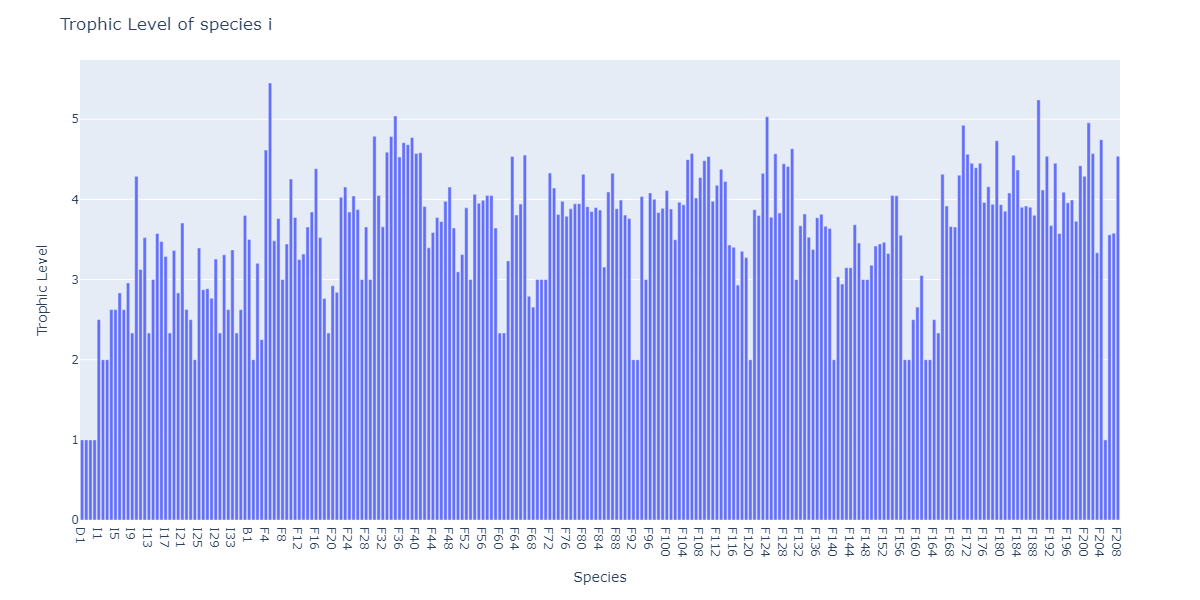

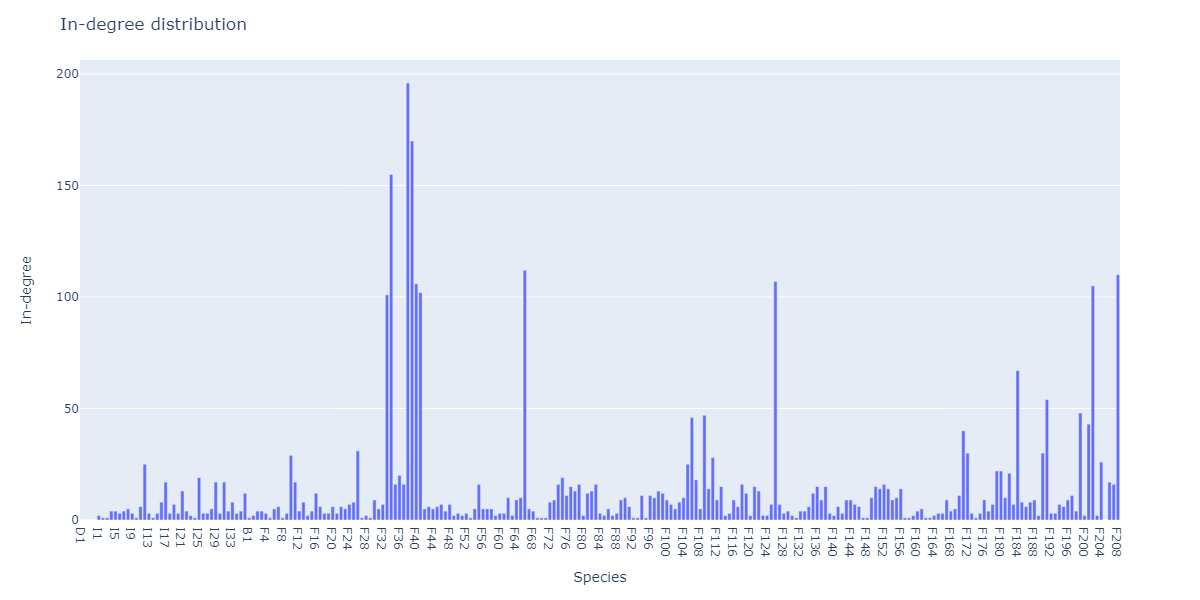

In [21]:
fig = px.bar(df_tl.reset_index(), x='index', y='trophic-level')

fig.update_layout(
    title="Trophic Level of species i",
    xaxis_title="Species",
    yaxis_title="Trophic Level",
    width=1200,
    height=600
)

if savegit: 
    path = "images/hw04_tl.png"
    fig.write_image(path)
    display(Image(path))
    
else:
    fig.show()
    

fig = px.bar(df_tl.reset_index(), x='index', y='in-degree')

fig.update_layout(
    title="In-degree distribution",
    xaxis_title="Species",
    yaxis_title="In-degree",
    width=1200,
    height=600
)

if savegit: 
    path = "images/hw04_in_degree.png"
    fig.write_image(path)
    display(Image(path))
    
else:
    fig.show()

### Degree distribution

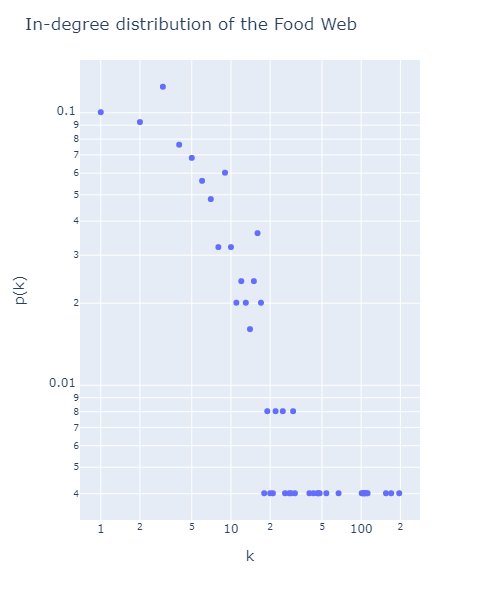

In [22]:
val, counts = np.unique(df_tl['in-degree'], return_counts=True)
prob_degree = counts/np.sum(counts)

df_ = pd.DataFrame({'degrees':val, 'pk':prob_degree})

fig = px.scatter(df_, x='degrees', y="pk")
fig.update_xaxes(type="log")
fig.update_yaxes(type="log")

fig.update_layout(
    title="In-degree distribution of the Food Web",
    xaxis_title="k",
    yaxis_title="p(k)",
    width=500,
    height=600
)

if savegit: 
    path = "images/hw04_degreedistribution.png"
    fig.write_image(path)
    display(Image(path))
    
else:
    fig.show()


Notice that the shape of this distribution is consistent with what typically happens in a real-world network. 

### Chain length
Length of the shortest path between a given top predator and a given basal species in the food chain. It is possible to compute:
- the average chain length
- the standard deviation of the chain length

In [23]:
top_pred = np.where(tl_vec>=int(np.max(tl_vec)))[0]
print('Top predators:', data.columns[1:][top_pred].tolist())

basal = np.where(tl_vec==1)[0]
print('Basal species:', data.columns[1:][basal].tolist())


Top predators: ['F5', 'F35', 'F124', 'F189']
Basal species: ['D1', 'A1', 'A2', 'A3', 'F205']


In [24]:
import networkx as nx

# DiGraph object 
G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)

# Find distances between each T and each B
pairs = [[B, T] for B in basal for T in top_pred]
chain_lengths = np.zeros(len(pairs))

for i, pair in enumerate(pairs):
    try: 
        chain_lengths[i] = nx.shortest_path_length(G, pair[0], pair[1])
    except:
        chain_lengths[i] = 0
        
# avg and std
print('Average chain length:', np.mean(chain_lengths))
print('Standard deviation of chain length:', np.std(chain_lengths))

Average chain length: 2.4
Standard deviation of chain length: 1.2


### Trophic coherence
Trophic coherence $q$ describes how neatly nodes fall into distinct levels of the network. First, the _trophic distance_ between $i$ and $j$ is defined as:
$$
    x_{ij} = S_i-S_j
$$
Assuming it as a random variable with $\langle X_{ij} \rangle=1$ we have that:
$$
    q = \sqrt{\langle X^2 \rangle-\langle X\rangle^2} = \sqrt{\frac{1}{L}\sum_{ij}a_{ij}X^2_{ij}-1}
$$

In [25]:
X_ij = tl_vec[:, np.newaxis]-tl_vec

q = np.sqrt(np.sum(adj_matrix*(X_ij**2))/L-1)
print('Trophic coherence of the Food Web: %.2f' %q)

Trophic coherence of the Food Web: 0.66


# Point 4
## The Cascade model
Consider an ecosystem of $S$ species and a connectance $C$. It is possible to build the random matrices following the following steps:
1. From a uniform distribution draw $S$ numbers $\eta_j\sim[0, 1]$, each associated to a species in the ecosystem. This numbers are called _Niche Values_ and represent the trophic level of the corresponding species. 
2. For each pair of species $i$ and $j$, if $\eta_i>\eta_j$ then species $i$ predates species $j$. It terms of the interaction matrix, this corresponds to creating a link between $i$ and $j$ with probability $P=2CS/(S-1)$.

The probability $P$ is chosen such that the average number of links $L$ is equal to:
$$
    \langle L\rangle = P\cdot \left(\text{\# pairs}\right) = \frac{2CS}{S-1}\cdot\frac{S(S-1)}{2} = CS^2
$$

The creation of the link follows the same steps as for the construction of the Random Matrices in the Predator-Prey case (see _Additional 1_): we set $M_{ji}$ and $M_{ij}$ by sampling them independently from, respectively, $|\mathcal{D}|$ and $-|\mathcal{D}|$. Here we consider $\mathcal{D}=\mathcal{N}(0, \sigma)$. Setting them to $\pm 1$ would instead lead to an antisymmetric matrix with pure imaginary eigenvalues, that is not what we want to observe. 

Moreover, another reason for this is that with this model, as the ones presented later, we want to represent a Predator-Prey structure and compare them with the results achived in _Additional 1_. This is why all diagonal elements, $M_{ii}$ are set to $−d$. 

In [26]:
# parameters
C = 0.45
d = 1
S = 100
sigma = 1

# cascade model
def cascade_1(size, diag, connectance, D=lambda: np.random.normal(0, 1)):
    '''
    INPUT:
    - size                   -> size of the square matrix (i.e. number of species) 
    - diag                   -> value of d (>0)
    - connectance            -> value of C (0<C<1)
    - D                      -> the selected distribution, by default a gaussian distribution
    
    OUTPUT:
    - M -> the random matrix
    
    '''
    M = np.zeros(shape=(size, size))

    NicheValues = np.random.uniform(size=size)
    prob_ = 2*connectance*size/(size-1)
    
    for i in range(size):
        for j in range(size):
            if NicheValues[i]>NicheValues[j]:
                if np.random.uniform()<=prob_:
                    M[j, i]=np.abs(D())
                    M[i, j]=-np.abs(D())
                    
    np.fill_diagonal(M, -diag)
    
    return M

In [27]:
# run again unstructured predator-prey
np.random.seed(1245)

# center and radius of the circle
center = [-d, 0]
radius = m.sqrt(S*C*sigma**2)

# initialize lists
N = 10
appended_data_pp = []

# build N random matrices with predator-prey structure
rho_values = []

for i in range(N):
    df_eig = pd.DataFrame(columns=['re', 'im', 'run'])
    
    M = randommatrix_cm_pp(S, d, C, competitivemutualistic=False)
    eig_M, _ = np.linalg.eig(M)
    df_eig['re'] = np.real(eig_M)
    df_eig['im'] = np.imag(eig_M)
    df_eig['run'] = [str(i+1)]*len(eig_M)
    
    appended_data_pp.append(df_eig)
    rho_values.append(correlation_zeromean(M, C, sigma))
    
appended_data_pp = pd.concat(appended_data_pp)
rho_pp = np.mean(rho_values)

# ellipses data
x0_pp, y0_pp, x1_pp, y1_pp = my_ellipse(center, S, C*sigma**2, rho_pp)

In [28]:
np.random.seed(1245)

# check behaviour with L
N = 200
numerical_L = []

for i in range(N):
    M = cascade_1(S, d, C)
    numerical_L.append(np.count_nonzero(M)/2)
    
L_ = np.mean(numerical_L)
L_std = np.std(numerical_L)

print('Expected average number of links (CS^2), L = %i' %(C*S**2))
print('Number of links over %i iterations, L= %i +- %.2f' %(N, L_, L_std))

Expected average number of links (CS^2), L = 4500
Number of links over 200 iterations, L= 4548 +- 18.51


In [29]:
np.random.seed(1245)

# build N random matrices
N = 10
appended_data_cascade = []

for i in range(N):
    df_eig = pd.DataFrame(columns=['re', 'im', 'run'])
    
    M = cascade_1(S, d, C)
    eig_M, _ = np.linalg.eig(M)
    df_eig['re'] = np.real(eig_M)
    df_eig['im'] = np.imag(eig_M)
    df_eig['run'] = [str(i+1)]*len(eig_M)
    
    appended_data_cascade.append(df_eig)
    
appended_data_cascade = pd.concat(appended_data_cascade)

It is possible to do a more generalized version of this model by introducing a particular symmetry among species. In this case a connection between $i$ and $j$ is created with probability: 
$$
    P(x)\simeq\beta(1-x)^{\beta-1}
$$
where $x= max\{0, \mu_i-\mu_j\}$ and $\beta$ is related to the connectance $C$ by the equation $C=S^2/[2(\beta+1)]$.


In [30]:
# cascade model
def cascade_2(size, diag, connectance, D=lambda: np.random.normal(0, 1)):
    '''
    INPUT:
    - size                   -> size of the square matrix (i.e. number of species) 
    - diag                   -> value of d (>0)
    - connectance            -> value of C (0<C<1)
    - D                      -> the selected distribution, by default a gaussian distribution
    
    OUTPUT:
    - M -> the random matrix
    
    '''
    
    M = np.zeros(shape=(size, size))

    NicheValues = np.random.uniform(size=size)
    beta = size**2/(2*connectance)-1
    
    for i in range(size):
        for j in range(i, size):
            x = np.max([0, NicheValues[i]-NicheValues[j]])
            prob_ = beta*(1-x)**(beta-1)
            
            p = np.random.uniform()
            if p<=prob_:
                M[i, j] = np.abs(D())
                M[j, i] = -np.abs(D())
                
    np.fill_diagonal(M, -diag)

    return M

In [31]:
np.random.seed(1245)

# build N random matrices
N = 10
appended_data_cascade_modified = []

for i in range(N):
    df_eig = pd.DataFrame(columns=['re', 'im', 'run'])
    
    M = cascade_2(S, d, C)
    eig_M, _ = np.linalg.eig(M)
    df_eig['re'] = np.real(eig_M)
    df_eig['im'] = np.imag(eig_M)
    df_eig['run'] = [str(i+1)]*len(eig_M)
    
    appended_data_cascade_modified.append(df_eig)
    
appended_data_cascade_modified = pd.concat(appended_data_cascade_modified)


## Plot of the results

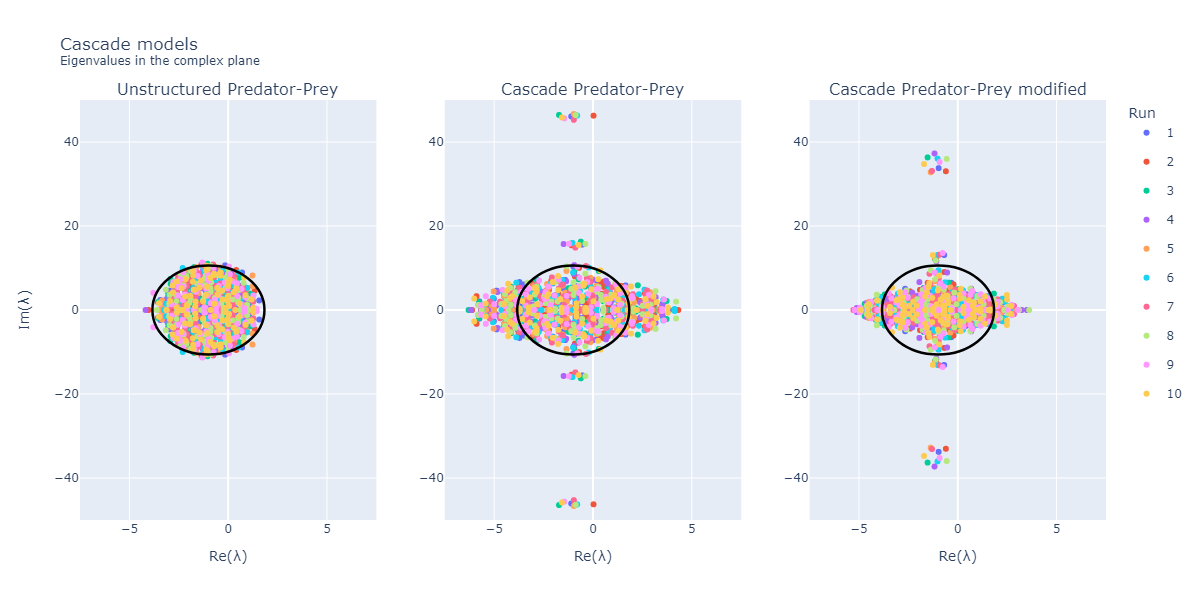

In [32]:
# organize datafames with different x-axes in a dict
dfs = {'df1': appended_data_pp,
       'df2': appended_data_cascade,
       'df3': appended_data_cascade_modified
}

# plot data
colors = px.colors.qualitative.Plotly
fig = make_subplots(
    rows=1, cols=3, subplot_titles=(
        "Unstructured Predator-Prey", 
        "Cascade Predator-Prey", 
        "Cascade Predator-Prey modified"
        )
)


for i, dfd in enumerate(dfs, start =1):
    for j, run in enumerate(dfs[dfd]['run'].unique()):
        df_ = dfs[dfd]
        df_ = df_[df_['run']==run]
        fig.add_trace(go.Scatter(x=df_['re'],
                        y=df_['im'],
                        mode = 'markers',
                        name=run,
                        marker_color=colors[j],
                        legendgroup = run,
                        showlegend = True if i == 1 else False,
                        ), row=1, col=i)


# unstructured 
fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=x0_pp, y0=y0_pp, x1=x1_pp, y1=y1_pp,
    line_color="black",
    line_width = 2.5, 
    row=1, col=1
)

# cascade 1
fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=x0_pp, y0=y0_pp, x1=x1_pp, y1=y1_pp,
    line_color="black",
    line_width = 2.5, 
    row=1, col=2
)

# cascade 2 
fig.add_shape(type="circle",
    xref="x", yref="y",
    x0=x0_pp, y0=y0_pp, x1=x1_pp, y1=y1_pp,
    line_color="black",
    line_width = 2.5, 
    row=1, col=3
)

# make the plot nice
for i in range(len(dfs)):
    fig.update_xaxes(range=[-7.5, 7.5], title_text='Re(λ)', row=1, col=i+1)
    fig.update_yaxes(range=[-50, 50], row=1, col=i+1) 

fig.update_yaxes(title_text='Im(λ)', row=1, col=1) 
# fig.update_yaxes(showticklabels=False, row=1, col=2)


# layout
fig.update_layout(
    height=600, width=1200, 
    title_text = "Cascade models<br><sup>Eigenvalues in the complex plane</sup>", 
    yaxis_title="Im(λ)",
    legend_title="Run")

if savegit: 
    path = "images/hw04_cascadeniche.png"
    fig.write_image(path)
    display(Image(path))
    
else:
    fig.show()

# Reference
Allesina, S., Tang, S. _Stability criteria for complex ecosystems_. Nature 483, 205–208 (2012). https://doi.org/10.1038/nature10832